In [1]:
import time
import dlib
import cv2
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Layla\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Layla\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Layla\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Layla\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')
detector = dlib.get_frontal_face_detector()

In [3]:
model = load_model('my_nnet.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
label_to_names = {
    0 : 'Harrison_Ford',
    1 : 'Dan_Radcliffe',
    2 : 'Emma_Watson',
    3 : 'Rupert_Grint',
    4 : 'Will_Smith',
    5 : 'Halle_Berry',
}
names_to_label = {
   'Harrison_Ford' : 0 ,
    'Dan_Radcliffe': 1,
    'Emma_Watson': 2,
    'Rupert_Grint': 3,
    'Will_Smith' :4,
    'Halle_Berry' : 5,
}

In [5]:
def get_vectors(img):
    descriptors = []
    dets = detector(img, 1)
    
    for k, d in enumerate(dets):
        shape = sp(img, d)
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        
        face_info = {
            'face_descriptor':np.array(face_descriptor),
            'coordinates' : [d.left(), d.top(), d.right(), d.bottom()],
        }
        descriptors.append(face_info)
        
    return descriptors

In [6]:
def make_prediction(vector):
    vector = np.expand_dims(vector, axis=0)
    prediction = model.predict_proba(vector)[0]
    index = np.argmax(prediction)
    value = prediction[index]
    print(value)
    if value > 0.80 and index == 4:
        label = label_to_names[index] + f'_{value*100:3.3f}'
    elif value > 0.70 and index == 5:
        label = label_to_names[index] + f'_{value*100:3.3f}'
    elif value > 0.75 and index == 1:
        label = label_to_names[index] + f'_{value*100:3.3f}'
    elif value > 0.80 and index == 2:
        label = label_to_names[index] + f'_{value*100:3.3f}'
    elif value > 0.85 and index == 3:
        label = label_to_names[index] + f'_{value*100:3.3f}'
    elif value > 0.80 and index == 0:
        label = label_to_names[index] + f'_{value*100:3.3f}'
    else:
        label = 'Unknown_person' + f'_{value*100:3.3f}'
        
    return label

In [7]:
def get_name_and_square(img):
    vectors = get_vectors(img)
    names_and_squares = []
    for vector in vectors:
        prediction = make_prediction(vector['face_descriptor'])
        info = {
            'name':prediction,
            'square' : vector['coordinates'],
        }
        names_and_squares.append(info)
    return names_and_squares

In [8]:
def show_img(image):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

In [16]:
def draw_info(img, info):
    x1, y1, x2, y2 = info['square']
    name = info['name']
    
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 >= img.shape[1]:
        x2 = img.shape[1] - 1
    if y2 >= img.shape[0]:
        y2 = img.shape[0] - 1
    fontsize = img.shape[1]/1000
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    img = cv2.putText(img, name, (x1, y1), cv2.FONT_ITALIC, fontsize, (0, 0, 255), 2)
    return img

In [17]:
img = cv2.imread('5.jpg')

In [18]:
infos = get_name_and_square(img)

0.54819024
0.948871
0.93122655
0.93438673


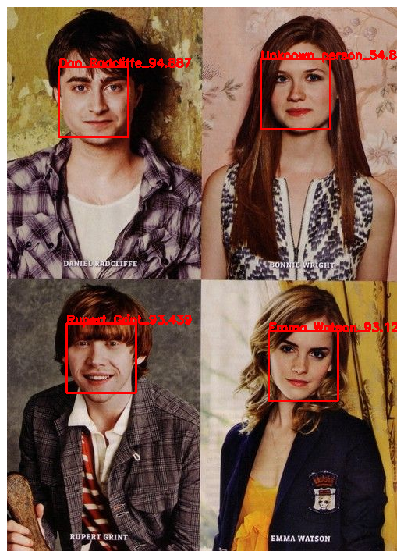

(697, 500, 3)

In [19]:
for info in infos:
    img = draw_info(img, info)
show_img(img)
img.shape

In [10]:
def make_video(input_video, output_video):
    video = cv2.VideoCapture(input_video)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH )
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT )
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    writer = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'DIVX'), int(fps), (int(width), int(height)))

    count = 0
    while video.isOpened():
        exist, frame = video.read()
        if exist:
            t = time.time()
            img = frame.copy()
            infos = get_name_and_square(img)
            for info in infos:
                img = draw_info(img, info)
            #cv2.imshow('frame', img)
            writer.write(img)
            spent = time.time() - t
            left = spent * (frame_count - count) / 60
            print(f'[{count} | {frame_count}] Time per frame: {spent:5.5f} Left: {left: 5.5f} mins.', end='\r')
            count += 1
        else:
            break
    #         if count >= 600:
    #             break

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    writer.release()
    cv2.destroyAllWindows()

In [20]:
make_video('cut_videos\\DR1.mp4', 'new_videos\\DR1.avi')

0.94802254
0.94840490] Time per frame: 4.33988 Left:  11.71768 mins.
0.94495136] Time per frame: 4.35403 Left:  11.68330 mins.
0.94096120] Time per frame: 4.30998 Left:  11.49328 mins.
0.94684815] Time per frame: 4.30132 Left:  11.39850 mins.
0.94556284] Time per frame: 4.32586 Left:  11.39143 mins.
0.93581110] Time per frame: 4.52590 Left:  11.84276 mins.
0.92434955] Time per frame: 4.56940 Left:  11.88045 mins.
0.93482980] Time per frame: 4.50543 Left:  11.63903 mins.
0.93004030] Time per frame: 4.88626 Left:  12.54141 mins.
0.93143520] Time per frame: 4.69699 Left:  11.97732 mins.
0.9276952.0] Time per frame: 4.72328 Left:  11.96565 mins.
0.9498261.0] Time per frame: 4.33857 Left:  10.91874 mins.
0.954048630] Time per frame: 4.35501 Left:  10.88751 mins.
0.9547539.0] Time per frame: 4.28360 Left:  10.63762 mins.
0.946601870] Time per frame: 4.28445 Left:  10.56831 mins.
0.9422772.0] Time per frame: 4.28411 Left:  10.49606 mins.
0.9473537.0] Time per frame: 4.28645 Left:  10.43037 mi

In [21]:
make_video('cut_videos\\DR2.mp4', 'new_videos\\DR2.avi')

0.9756328
0.97596130] Time per frame: 4.31456 Left:  14.45379 mins.
0.97733720] Time per frame: 4.29241 Left:  14.30804 mins.
0.97646910] Time per frame: 4.30134 Left:  14.26612 mins.
0.97773325] Time per frame: 4.31723 Left:  14.24687 mins.
0.97759116] Time per frame: 4.28488 Left:  14.06870 mins.
0.97765940] Time per frame: 4.29372 Left:  14.02616 mins.
0.97600730] Time per frame: 4.28932 Left:  13.94028 mins.
0.97639024] Time per frame: 4.30567 Left:  13.92165 mins.
0.97651684] Time per frame: 4.42390 Left:  14.23023 mins.
0.97699076] Time per frame: 4.48692 Left:  14.35813 mins.
0.974990070] Time per frame: 4.37247 Left:  13.91902 mins.
0.975253160] Time per frame: 4.40098 Left:  13.93644 mins.
0.9760591.0] Time per frame: 4.40687 Left:  13.88164 mins.
0.976531740] Time per frame: 4.31202 Left:  13.51099 mins.
0.9771015.0] Time per frame: 4.30188 Left:  13.40753 mins.
0.9773548.0] Time per frame: 4.30596 Left:  13.34847 mins.
0.976890560] Time per frame: 4.33534 Left:  13.36730 min

In [14]:
make_video('cut_videos\\EW.mp4', 'new_videos\\EW.avi')

0.897597
0.9479614
0.897597.0] Time per frame: 6.12031 Left:  14.07671 mins.
0.95330906
0.897597.0] Time per frame: 6.10642 Left:  13.94300 mins.
0.94911397
0.897597.0] Time per frame: 6.12797 Left:  13.89007 mins.
0.94249344
0.897597.0] Time per frame: 6.14381 Left:  13.82358 mins.
0.9482431
0.897597.0] Time per frame: 6.11810 Left:  13.66375 mins.
0.9436062
0.897597.0] Time per frame: 6.16041 Left:  13.65557 mins.
0.94486886
0.897597.0] Time per frame: 6.17616 Left:  13.58756 mins.
0.953315
0.897597.0] Time per frame: 6.16794 Left:  13.46668 mins.
0.95134765
0.897597.0] Time per frame: 6.15633 Left:  13.33872 mins.
0.9432818
0.897597.0] Time per frame: 6.11367 Left:  13.14439 mins.
0.9437707
0.8975978.0] Time per frame: 6.12779 Left:  13.07262 mins.
0.91873074
0.8975978.0] Time per frame: 6.15094 Left:  13.01949 mins.
0.91099584
0.8975978.0] Time per frame: 6.15601 Left:  12.92763 mins.
0.9233996
0.8975978.0] Time per frame: 6.19385 Left:  12.90386 mins.
0.9339844
0.8975978.0] Time p

In [22]:
make_video('cut_videos\\HB.mp4', 'new_videos\\HB.avi')

0.95964706
0.77791715] Time per frame: 4.33080 Left:  16.81795 mins.
0.98078674] Time per frame: 4.33292 Left:  16.75397 mins.
0.94401610] Time per frame: 4.34590 Left:  16.73172 mins.
0.67863590] Time per frame: 2.48531 Left:  9.48561 mins..
0.92905050] Time per frame: 4.32165 Left:  16.42228 mins.
0.75479007] Time per frame: 4.32065 Left:  16.34645 mins.
0.90824570] Time per frame: 2.52661 Left:  9.47481 mins..
0.92273694] Time per frame: 4.33777 Left:  16.19436 mins.
0.650674760] Time per frame: 4.34294 Left:  16.14125 mins.
0.7435344.0] Time per frame: 4.36511 Left:  16.15090 mins.
0.7418555.0] Time per frame: 4.34821 Left:  16.01592 mins.
0.762391270] Time per frame: 4.34812 Left:  15.94310 mins.
0.589881660] Time per frame: 4.31156 Left:  15.73718 mins.
0.791374440] Time per frame: 4.29753 Left:  15.61436 mins.
0.6620593.0] Time per frame: 4.31985 Left:  15.62345 mins.
0.5334782.0] Time per frame: 4.31736 Left:  15.54250 mins.
0.805322350] Time per frame: 4.29366 Left:  15.38563 

In [23]:
make_video('cut_videos\\HF.mp4', 'new_videos\\HF.avi')

0.47424614] Time per frame: 2.50095 Left:  13.13001 mins.
0.504660370] Time per frame: 2.50191 Left:  13.05165 mins.
0.5363829.0] Time per frame: 2.50326 Left:  12.93349 mins.
0.5391477.0] Time per frame: 4.31338 Left:  22.21392 mins.
0.729498150] Time per frame: 4.30790 Left:  22.11389 mins.
0.6884207.0] Time per frame: 4.34434 Left:  22.22854 mins.
0.7422974.0] Time per frame: 4.29443 Left:  21.90160 mins.
0.7601232.0] Time per frame: 4.31364 Left:  21.92765 mins.
0.58725446
0.411461060] Time per frame: 6.12502 Left:  31.03341 mins.
0.335247040] Time per frame: 4.29538 Left:  21.69168 mins.
0.7358556.0] Time per frame: 4.31193 Left:  21.70336 mins.
0.678065
0.5715948.0] Time per frame: 6.14715 Left:  30.83819 mins.
0.7394758.0] Time per frame: 2.48974 Left:  12.40723 mins.
0.7423313.0] Time per frame: 4.30330 Left:  21.37307 mins.
0.6000454.0] Time per frame: 4.29287 Left:  21.24969 mins.
0.753766540] Time per frame: 2.49245 Left:  12.25454 mins.
0.801635860] Time per frame: 4.30539 

0.94021784.0] Time per frame: 4.31406 Left:  3.52315 mins.
0.94093126.0] Time per frame: 4.32051 Left:  3.45641 mins.
0.94088393.0] Time per frame: 4.29954 Left:  3.36797 mins.
0.92166374.0] Time per frame: 4.33358 Left:  3.32241 mins.
0.93287024.0] Time per frame: 4.35617 Left:  3.26713 mins.
0.92250114.0] Time per frame: 4.34305 Left:  3.18490 mins.
0.93367124.0] Time per frame: 4.33035 Left:  3.10342 mins.
0.93545124.0] Time per frame: 4.33214 Left:  3.03250 mins.
0.92287374.0] Time per frame: 4.33598 Left:  2.96292 mins.
0.90471574.0] Time per frame: 4.29760 Left:  2.86507 mins.
0.91948294.0] Time per frame: 4.28674 Left:  2.78638 mins.
0.93370134.0] Time per frame: 4.31599 Left:  2.73346 mins.
0.92404175.0] Time per frame: 4.31253 Left:  2.65940 mins.
0.90203814.0] Time per frame: 4.32632 Left:  2.59579 mins.
0.89895535.0] Time per frame: 4.30665 Left:  2.51221 mins.
0.93244314.0] Time per frame: 4.29553 Left:  2.43414 mins.
0.88935154.0] Time per frame: 4.31731 Left:  2.37452 min

In [24]:
make_video('cut_videos\\HP.mp4', 'new_videos\\HP.avi')

0.9153846
0.92078830] Time per frame: 4.35167 Left:  17.91436 mins.
0.92557526] Time per frame: 4.33169 Left:  17.75991 mins.
0.93477666] Time per frame: 4.32506 Left:  17.66065 mins.
0.91328680] Time per frame: 4.33370 Left:  17.62371 mins.
0.92745060] Time per frame: 4.32454 Left:  17.51437 mins.
0.91923270] Time per frame: 4.38607 Left:  17.69047 mins.
0.91505694] Time per frame: 4.27711 Left:  17.17971 mins.
0.88435960] Time per frame: 4.29800 Left:  17.19200 mins.
0.83567303] Time per frame: 4.31167 Left:  17.17481 mins.
0.78613317] Time per frame: 4.30737 Left:  17.08589 mins.
0.7808907.0] Time per frame: 4.29927 Left:  16.98213 mins.
0.847665670] Time per frame: 4.34766 Left:  17.10079 mins.
0.8918927.0] Time per frame: 4.32274 Left:  16.93073 mins.
0.866155270] Time per frame: 4.29154 Left:  16.73700 mins.
0.877597870] Time per frame: 4.32168 Left:  16.78253 mins.
0.8803886.0] Time per frame: 4.32358 Left:  16.71786 mins.
0.880176370] Time per frame: 4.30289 Left:  16.56612 min

In [18]:
make_video('cut_videos\\RG.mp4', 'new_videos\\RG.avi')

0.9579118
0.95615610] Time per frame: 4.30870 Left:  10.91537 mins.
0.95109624] Time per frame: 4.30391 Left:  10.83150 mins.
0.95504695] Time per frame: 4.27652 Left:  10.69131 mins.
0.94642943] Time per frame: 4.27297 Left:  10.61121 mins.
0.95526270] Time per frame: 4.29868 Left:  10.60341 mins.
0.94647115] Time per frame: 4.30189 Left:  10.53962 mins.
0.94736740] Time per frame: 4.31011 Left:  10.48792 mins.
0.94015440] Time per frame: 4.31877 Left:  10.43704 mins.
0.92715420] Time per frame: 4.31118 Left:  10.34683 mins.
0.94126460] Time per frame: 4.30871 Left:  10.26909 mins.
0.9644077.0] Time per frame: 4.29985 Left:  10.17632 mins.
0.958460150] Time per frame: 4.31959 Left:  10.15104 mins.
0.964157040] Time per frame: 4.30758 Left:  10.05102 mins.
0.963815450] Time per frame: 4.30111 Left:  9.96423 mins.
0.9687191.0] Time per frame: 4.30688 Left:  9.90582 mins.
0.9537998.0] Time per frame: 4.29435 Left:  9.80542 mins.
0.9494577.0] Time per frame: 4.30807 Left:  9.76497 mins.
0

In [25]:
make_video('cut_videos\\WS.mp4', 'new_videos\\WS.avi')

0.66321385
0.60678960] Time per frame: 4.33769 Left:  8.53079 mins.
0.93132520] Time per frame: 4.31905 Left:  8.42215 mins.
0.96907926] Time per frame: 2.48696 Left:  4.76668 mins.
0.61008716
0.96673670] Time per frame: 6.18983 Left:  11.76069 mins.
0.93164694] Time per frame: 4.33545 Left:  8.16509 mins.
0.67817336
0.96775490] Time per frame: 6.17999 Left:  11.53599 mins.
0.81014520] Time per frame: 4.31920 Left:  7.99052 mins.
0.96629910] Time per frame: 4.32999 Left:  7.93832 mins.
0.978985670] Time per frame: 2.48675 Left:  4.43471 mins.
0.963033560] Time per frame: 4.30676 Left:  7.60861 mins.
0.965692760] Time per frame: 4.28998 Left:  7.50747 mins.
0.9704038.0] Time per frame: 4.30149 Left:  7.45591 mins.
0.9757524.0] Time per frame: 2.48736 Left:  4.22851 mins.
0.7314838.0] Time per frame: 4.30978 Left:  7.25480 mins.
0.890125630] Time per frame: 4.32763 Left:  7.21272 mins.
0.9625373.0] Time per frame: 4.30293 Left:  7.09984 mins.
0.9677118.0] Time per frame: 4.33722 Left:  7

In [11]:
make_video('cut_videos\\HF2.mp4', 'new_videos\\HF2.avi')

0.96506095
0.96518630] Time per frame: 4.52111 Left:  9.79573 mins.
0.96485060] Time per frame: 4.38678 Left:  9.43158 mins.
0.96307480] Time per frame: 4.64972 Left:  9.91940 mins.
0.96313920] Time per frame: 4.65568 Left:  9.85453 mins.
0.95844865] Time per frame: 4.67890 Left:  9.82569 mins.
0.94992274] Time per frame: 4.69389 Left:  9.77893 mins.
0.94267994] Time per frame: 4.69744 Left:  9.70805 mins.
0.94356596] Time per frame: 4.66132 Left:  9.55571 mins.
0.93257135] Time per frame: 4.64038 Left:  9.43544 mins.
0.94010820] Time per frame: 4.38686 Left:  8.84683 mins.
0.9281305.0] Time per frame: 4.35420 Left:  8.70839 mins.
0.933880030] Time per frame: 4.31511 Left:  8.55831 mins.
0.9402024.0] Time per frame: 4.41078 Left:  8.67453 mins.
0.9421288.0] Time per frame: 4.40304 Left:  8.58593 mins.
0.943555360] Time per frame: 4.41474 Left:  8.53517 mins.
0.9541502.0] Time per frame: 4.46551 Left:  8.55888 mins.
0.9534406.0] Time per frame: 4.69004 Left:  8.91107 mins.
0.9628285.0] 

In [13]:
make_video('cut_videos\\DR2.mp4', 'new_videos\\DR2.avi')

0.9016366
0.90190774] Time per frame: 4.65485 Left:  11.01649 mins.
0.90136330] Time per frame: 4.54930 Left:  10.69086 mins.
0.91527224] Time per frame: 4.62810 Left:  10.79890 mins.
0.91492230] Time per frame: 4.52047 Left:  10.47241 mins.
0.92955804] Time per frame: 4.49028 Left:  10.32764 mins.
0.92639510] Time per frame: 4.71806 Left:  10.77290 mins.
0.90410090] Time per frame: 4.68659 Left:  10.62294 mins.
0.89485060] Time per frame: 4.74482 Left:  10.67585 mins.
0.88944525] Time per frame: 5.00634 Left:  11.18082 mins.
0.91753130] Time per frame: 6.17741 Left:  13.69326 mins.
0.9112957.0] Time per frame: 4.77937 Left:  10.51462 mins.
0.9060845.0] Time per frame: 4.44260 Left:  9.69967 mins.
0.880276140] Time per frame: 4.45703 Left:  9.65690 mins.
0.8814186.0] Time per frame: 4.45537 Left:  9.57906 mins.
0.8892036.0] Time per frame: 4.42181 Left:  9.43320 mins.
0.8869093.0] Time per frame: 4.55711 Left:  9.64589 mins.
0.892065470] Time per frame: 4.36583 Left:  9.16823 mins.
0.8

In [14]:
video.release()
writer.release()
cv2.destroyAllWindows()